# Recognizing sentence punctuation

This notebook is roughly based on [an online tutorial](https://www.tensorflow.org/text/tutorials/transformer).



In [1]:
import tensorflow as tf

2024-09-13 21:43:51.851767: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 21:43:51.854893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 21:43:51.863584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 21:43:51.878458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 21:43:51.883162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 21:43:51.894471: I tensorflow/core/platform/cpu_feature_gu

## Prepare the training data

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow_datasets as tfds


We gather training data from a variety of sources, including the Tensorflow datasets `ai2_arc_with_ir` and `mlqa`.

In [3]:
dataset_raw_train = tfds.load('ai2_arc_with_ir', split='train', shuffle_files=True)
dataset_raw_test = tfds.load('ai2_arc_with_ir', split='test', shuffle_files=True)
dataset_raw = dataset_raw_train.concatenate(dataset_raw_test)
dataset_raw = dataset_raw.map(lambda x: x['paragraph'])
for i in dataset_raw.take(1):
	print(i)

tf.Tensor(b'It and the other noble gases - helium, neon, krypton, xenon, and radon - will react with other substances only under extreme conditions. The noble gases The noble, or inert, gases are helium, neon, argon, krypton, xenon and radon. The rare gases are helium, neon, argon, krypton or xenon. The noble "gases" are helium, neon, argon, krypton and xenon. The noble gases are helium, neon, argon, krypton, xenon and radon. These occur for the noble gases helium, neon, argon, krypton, xenon, radon and ununoctium. Because of their chemical inertness, the elements in this group are called the Nobel Gases : Helium Neon Argon Krypton Xenon Radon Group I Elements The elements in this group have one electron in their outer electronic shell. The inert, or noble, gases (helium, neon, argon, krypton, xenon, and radon) all have completely filled outer shells. The other noble gases, which together make about 1% of the Earth\'s atmosphere, are neon, argon, krypton, xenon and radon. Most of the n

2024-09-13 21:43:53.837036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-13 21:43:53.838038: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_raw_mlqa = tfds.load('mlqa/en', split='test', shuffle_files=True) # "train" not available
dataset_raw_mlqa = dataset_raw_mlqa.map(lambda x: x['context'])
dataset_raw = dataset_raw_mlqa.concatenate(dataset_raw)

We also have some custom data (stored in the `data/` directory). This data is loading using [`tf.data.TextLineDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset). Each line in the source files is mapped to a new training example. 

In [5]:
data_file_paths = list(Path('data/processed/en/').glob('*.txt'))
dataset_raw = dataset_raw.concatenate(
	tf.data.TextLineDataset(data_file_paths)
)

Now that we have our data, let's do some preprocessing. In particular:
- Very short training examples will be removed.
- Very long training examples will be split.
- Unsupported characters will be removed.

In [6]:
def remove_unsupported_characters(s):
	return tf.strings.regex_replace(s, r'[^A-Za-z0-9ùúûüÿàâæçéèêëïîôœÙÚÛÜŸÀÂÆÇÉÈÊËÏÎÔŒ \t\n.,?!\-\':;&]', '')
dataset_raw = dataset_raw.map(remove_unsupported_characters)

In [7]:

def break_long_sequences(paragraph):
	return tf.strings.regex_replace(paragraph, r'.{0,164}[.?]', r'\0 [SEP]')

def split_on_separators(text):
	return tf.data.Dataset.from_tensor_slices(tf.strings.split(text, '[SEP]'))

def filter_paragraphs(context, target):
	return tf.strings.length(context) > 5 and tf.strings.length(target) > 5

punctuation_chars = r'\?!.,"\-\':;'
def add_context(target):
	context = tf.strings.regex_replace(target, r'[\-]{2,}', ' - ')
	context = tf.strings.regex_replace(context, r'[\-\']', '')
	context = tf.strings.regex_replace(context, '[?.!:]+', ' ')
	context = tf.strings.strip(
		tf.strings.regex_replace(context, '[ ]+', ' ')
	)
	context = tf.strings.lower(context)
	return context, target

dataset_raw = dataset_raw.map(break_long_sequences).flat_map(split_on_separators).map(add_context).filter(filter_paragraphs)


Now let's inspect the data:

In [8]:
table = []

for context, target in dataset_raw.take(6).as_numpy_iterator():
	table.append('<tr><td><code>{}</code></td><td><code>{}</code></td></tr>'.format(context.decode('utf-8'), target.decode('utf-8')))

display.display(
	display.HTML('''<table>
			  		<thead><th>Context</th><th>Target</th></thead>
			  		<tbody>{}</tbody>
			  		</table>'''.format('\n'.join(table))))

2024-09-13 21:43:54.217869: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-13 21:43:54.218715: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


"after completing the journey around south america, on 23 february 2006, queen mary 2 met her namesake, the original rms queen mary, which is permanently docked at long beach, california","After completing the journey around South America, on 23 February 2006, Queen Mary 2 met her namesake, the original RMS Queen Mary, which is permanently docked at Long Beach, California."
"escorted by a flotilla of smaller ships, the two queens exchanged a whistle salute which was heard throughout the city of long beach","Escorted by a flotilla of smaller ships, the two Queens exchanged a whistle salute which was heard throughout the city of Long Beach."
"queen mary 2 met the other serving cunard liners queen victoria and queen elizabeth 2 on 13 january 2008 near the statue of liberty in new york city harbour, with a celebratory fireworks display; queen elizabeth 2 and queen victoria made a tandem crossing of the atlantic for the meeting","Queen Mary 2 met the other serving Cunard liners Queen Victoria and Queen Elizabeth 2 on 13 January 2008 near the Statue of Liberty in New York City harbour, with a celebratory fireworks display; Queen Elizabeth 2 and Queen Victoria made a tandem crossing of the Atlantic for the meeting."
this marked the first time three cunard queens have been present in the same location,This marked the first time three Cunard Queens have been present in the same location.
"cunard stated this would be the last time these three ships would ever meet, due to queen elizabeth 2s impending retirement from service in late 2008","Cunard stated this would be the last time these three ships would ever meet, due to Queen Elizabeth 2's impending retirement from service in late 2008."
"however this would prove not to be the case, as the three queens met in southampton on 22 april 2008","However this would prove not to be the case, as the three Queens met in Southampton on 22 April 2008."


### Batching

In [9]:
BUFFER_SIZE = 100_000
BATCH_SIZE = 64
dataset_train = dataset_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

validate_size = 4 # batches
dataset_validate = dataset_train.take(validate_size)
dataset_train = dataset_train.skip(validate_size)

### Preparing to process data

The [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer takes a `standardize` option that preprocesses input data. The default removes punctuation, but we don't want that. Let's redefine it:

In [10]:

def standardize_tf_text(text):
	punctuation_regex = '[{p}]'.format(p = punctuation_chars)

	# Clean up &quot artifacts
	text = tf.strings.regex_replace(text, r'&quot;?', r' " ')

	# Surround punctuation with spaces for easier tokenization
	text = tf.strings.regex_replace(text, punctuation_regex, r' \0 ')

	# Remove repeated spaces
	text = tf.strings.regex_replace(text, r'\s+', ' ')

	# Add a special "capitalize the next letter" token
	text = tf.strings.regex_replace(text, r'(\s|^)([A-Z])', r' [CAP] \2')

	# Lowercase everything
	text = tf.strings.lower(text)

	# English specific: Move -ing, -s suffixes to new words
	text = tf.strings.regex_replace(text, r'([a-z]{3,})(ing|er|ed|ily|ly|ish|s)(\s|$)', r'\1 [\2]\3')

	# Remove leading and trailing spaces
	text = tf.strings.strip(text)

	# Add sequence markings
	return tf.strings.join(['[START]', text, '[END]'], separator=' ')

print(standardize_tf_text('This is a test! It\'s working?!'))

tf.Tensor(b"[START] [cap] thi [s] is a test ! [cap] it ' s work [ing] ? ! [END]", shape=(), dtype=string)


The text standardization function can now be used to preprocess text:

In [11]:
# Keep only the 4000 most commonly used tokens
max_vocab_size = 4000

target_text_processor = tf.keras.layers.TextVectorization(
	standardize=standardize_tf_text,
	max_tokens=max_vocab_size,
	# Allow entries of different lengths
	ragged=True,
)
target_text_processor.adapt(dataset_train.map(lambda context, target: target))

print('First 14 target words:', target_text_processor.get_vocabulary()[:14])

# The target data should be roughly equivalent to the context data, except have additional (punctuation)
# tokens.
context_text_processor = target_text_processor

First 14 target words: ['', '[UNK]', '[cap]', '[s]', ',', 'the', '.', '[ed]', '[START]', '[END]', 'of', 'and', '[er]', 'to']


The `TextVectorization` layer is created here (after batching) to exclude the validation data from the data given to `target_text_processor.adapt`.

The `context_text_processor` and `target_text_processor` can be used as follows:

In [12]:
example_text = 'hello world this is a test tensorflow is processing this'
example_tokens = context_text_processor(example_text)
print('Example tokens', example_tokens)

context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens.numpy()]
print('Back to text', ' '.join(tokens))

Example tokens tf.Tensor(
[   8    1  129   45    3   22   16  550    1   22 3834   14   45    3
    9], shape=(15,), dtype=int64)
Back to text [START] [UNK] world thi [s] is a test [UNK] is process [ing] thi [s] [END]


### Processing the data

Now, we'll:
1. Map the data through the text processors we just made.
2. Shift the target data, so that our network is provided with a history of generated tokens.

In [13]:
def process_text(context, target):
	return context_text_processor(context), target_text_processor(target)

print(dataset_train.map(process_text))

def add_target_history(context, target):
	# .to_tensor(): Converts from RaggedTensors to Tensors.
	# We give our network the history as target_in
	target_in = target[:, :-1].to_tensor()
	target_out = target[:, 1:].to_tensor()
	return (context.to_tensor(), target_in), target_out
dataset_train = dataset_train.map(process_text).map(add_target_history).repeat()
dataset_validate = dataset_validate.map(process_text).map(add_target_history)

<_MapDataset element_spec=(RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.int64, 1, tf.int64))>


In [14]:

def inspect_dataset(dataset: tf.data.Dataset):
	target_vocab = np.array(target_text_processor.get_vocabulary())
	for (context, target_in), target_out in dataset.take(1):
		context_words = context_vocab[context[0]]
		print('context', ','.join(context_words))
		print('target_in', ','.join(target_vocab[target_in[0]]))
		print('target_out', ','.join(target_vocab[target_out[0]]))

inspect_dataset(dataset_train)

2024-09-13 21:44:33.381745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:53: Filling up shuffle buffer (this may take a while): 98842 of 100000
2024-09-13 21:44:33.535434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


context [START],in,the,republic,of,india,,,a,chief,minist,[er],is,the,head,of,government,of,each,of,[UNK],state,[s],and,two,union,territorie,[s],[UNK],and,[UNK],[END],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
target_in [START],[cap],in,the,[cap],republic,of,[cap],india,,,a,chief,minist,[er],is,the,head,of,government,of,each,of,twenty,-,nine,state,[s],and,two,union,territorie,[s],[cap],[UNK],and,[cap],[UNK],.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
target_out [cap],in,the,[cap],republic,of,[cap],india,,,a,chief,minist,[er],is,the,head,of,government,of,each,of,twenty,-,nine,state,[s],and,two,union,territorie,[s],[cap],[UNK],and,[cap],[UNK],.,[END],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


2024-09-13 21:44:33.752277: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**TODO**: Based on some of the above output, do we need to filter out certain training examples? The model *can* try to correct sentences if it thinks that a word is unlikely. We probably don't want it to do this unless certain examples are removed from the training data.

## Model

### Embedding

The model won't contain recurrent layers. As such, we must provide some way to determine word order. This will be done by adding **positional encoding** to the word embeddings. They have the same dimension, $d$, as the embeddings (see https://arxiv.org/html/1706.03762v7)
$$
	\texttt{PE}_{\cos}(pos) = \cos \begin{pmatrix} \frac{pos}{10000^{0/d}} \\ \frac{pos}{10000^{1/d}} \\ \frac{pos}{10000^{2/d}} \\ \vdots\\ \frac{pos}{10000^{(d-1)/d}}  \\ \frac{pos}{10000^{d/d}} \end{pmatrix},
$$
where $\cos$ acts elementwise on the vector of $\frac{pos}{10000^{i/d}}$. This is then concatenated with
$$
	\texttt{PE}_{\sin}(pos) = \sin \begin{pmatrix} \frac{pos}{10000^{0/d}} \\ \frac{pos}{10000^{1/d}} \\ \frac{pos}{10000^{2/d}} \\ \vdots\\ \frac{pos}{10000^{(d-1)/d}}  \\ \frac{pos}{10000^{d/d}} \end{pmatrix}.
$$



In [15]:
def build_positional_encoding(embedding_dimen: int, seq_length: int):
	# Halve the embedding dimension so that the final output column count will be the same
	# as the original embedding_dimen.
	embedding_dimen //= 2

	positions = tf.range(seq_length, dtype=tf.float32) # (seq_length,)
	indexes = tf.range(embedding_dimen, dtype=tf.float32) / embedding_dimen # (embedding_dimen,)
	rates = 1 / (10000**indexes)
	# Reshape positions and rates such that when multiplied, they form a 2×2 matrix
	angles = tf.reshape(positions, [-1, 1]) * tf.reshape(rates, [1, -1]) # (seq_length, embedding_dimen)

	encoding = tf.concat([ tf.cos(angles), tf.sin(angles) ], 1) # (seq_length, 2 × embedding_dimen)
	return tf.cast(encoding, dtype=tf.float32)

print(build_positional_encoding(6, 6))

tf.Tensor(
[[ 1.          1.          1.          0.          0.          0.        ]
 [ 0.5403023   0.998923    0.9999977   0.84147096  0.04639922  0.00215443]
 [-0.4161468   0.9956942   0.9999907   0.9092974   0.09269849  0.00430886]
 [-0.9899925   0.9903207   0.99997914  0.14112     0.13879809  0.00646326]
 [-0.6536436   0.98281395  0.99996287 -0.7568025   0.18459871  0.00861763]
 [ 0.28366217  0.97319025  0.999942   -0.9589243   0.23000169  0.01077196]], shape=(6, 6), dtype=float32)


We can visualize the positional encoding on a grid:

Visualizing positional encoding:


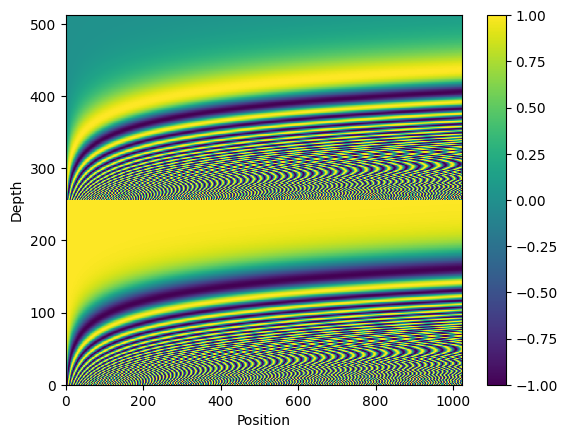

In [16]:
fig, ax = plt.subplots()
m = ax.pcolormesh(build_positional_encoding(512,1024).numpy().T)
ax.set_ylabel('Depth')
ax.set_xlabel('Position')
fig.colorbar(m)

print('Visualizing positional encoding:')

This can be used to create a layer that adds the position embedding information to its input.

In [17]:
class PositionalEmbedding(tf.keras.Layer):
	def __init__(self, vocab_size: int, embedding_dim: int):
		super().__init__()
		self.embedding_dim = embedding_dim
		self.vocab_size = vocab_size
		self.embedding_layer = tf.keras.layers.Embedding(
			vocab_size,
			embedding_dim,
			mask_zero = True,
		)
		# Supports sequences shorter than 2048
		max_seq_len = 2048
		self.pos_encoding_mat = build_positional_encoding(embedding_dim, seq_length=max_seq_len)

	def compute_mask(self, inputs, mask=None):
		# See https://www.tensorflow.org/guide/keras/understanding_masking_and_padding#supporting_masking_in_your_custom_layers
		return self.embedding_layer.compute_mask(inputs, mask)
	
	def call(self, x):
		batch_size, seq_length = tf.shape(x)
		x = self.embedding_layer(x)
		# Follow the original paper in scaling the embeddings by sqrt(embedding_dim) before adding
		# positional encoding:
		x *= tf.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32)) # tf.sqrt doesn't support ints
		x += self.pos_encoding_mat[None, : seq_length, :]
		return x

context_vocab = context_text_processor.get_vocabulary()
context_embed = PositionalEmbedding(vocab_size=len(context_vocab), embedding_dim=512)
sample_embed = context_embed(np.array([ [ 1, 2, 3 ] ]))
print(sample_embed)

tf.Tensor(
[[[ 1.0992762   0.54773587  1.8323889  ... -0.1877041   0.6204534
   -0.72128296]
  [ 1.0972424   0.50390166  0.8222046  ... -0.0856367  -0.02513639
    0.86513525]
  [-0.03062901 -0.6813883   0.06448856 ... -0.9932805  -0.7406619
    0.70914537]]], shape=(1, 3, 512), dtype=float32)


### The attention layers

We'll be using several different attention layer variations. To support this, we extract the shared functionality into an abstract base class:

In [18]:
class BaseAttention(tf.keras.Layer):
	""" Wraps [layers.MultiHeadAttention], with `LayerNormalization` and `Add` layers preconstructed. """
	def __init__(self, **kwargs):
		super().__init__()
		self.mha_layer = tf.keras.layers.MultiHeadAttention(**kwargs)
		# Keeps "the mean activation within each example close to 0 and the
		# activation standard deviation close to 1" -- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization?hl=en
		self.norm_layer = tf.keras.layers.LayerNormalization()
		self.add_layer = tf.keras.layers.Add() # Use instead of + to preserve masking information

		self.supports_masking = True


In [19]:
class CrossAttention(BaseAttention):
	def call(self, query, value):
		attention_output, attention_scores = self.mha_layer(
			query = query,
			value = value,
			#use_causal_mask=True,
			# Return the attention scores for latter plotting
			return_attention_scores = True,
		)

		self.last_attention_scores = attention_scores

		# Add the query back in -- encourages the attention layer to modify the query, rather than
		# replace it.
		x = self.add_layer([ query, attention_output ])
		x = self.norm_layer(x)
		return x

class GlobalSelfAttention(BaseAttention):
	""" GlobalSelfAttention acts like the bidirectional RNN used for the encoder
	    in the seq2seq tutorial -- its job is to capture information about the
		entire input sequence.
	"""
	def call(self, x):
		attention_output = self.mha_layer(query = x, value = x)
		x = self.add_layer([ x, attention_output ])
		x = self.norm_layer(x)
		return x
	
class CausalSelfAttention(BaseAttention):
	""" Like GlobalSelfAttention, but ensures that each input token has access
	    only to the tokens that precede it.
	"""
	def call(self, x):
		# use_causal_mask: Ensures that each input only has access to those that come
		#                  before. This is important because at each step, our model
		#                  is given the previous outputs and produces the next output.
		attention_output = self.mha_layer(query = x, value = x, use_causal_mask = True)
		x = self.add_layer([ x, attention_output ])
		return self.norm_layer(x)

Next, we have a feed-forward network:

In [20]:
class FeedForward(tf.keras.Layer):
	def __init__(self, encoder_dimen, feed_forward_dimen, dropout_rate = 0.1):
		super().__init__()
		self.sequental_layer = tf.keras.Sequential([
			tf.keras.layers.Dense(feed_forward_dimen, activation='relu'),
			tf.keras.layers.Dense(encoder_dimen),
			tf.keras.layers.Dropout(dropout_rate),
		])
		self.add_layer = tf.keras.layers.Add()
		self.norm_layer = tf.keras.layers.LayerNormalization()
		self.supports_masking = True
	
	def call(self, x):
		x = self.add_layer([ x, self.sequental_layer(x) ])
		return self.norm_layer(x)

In [21]:
class EncoderLayer(tf.keras.Layer):
	def __init__(self, encoder_dimen: int, num_heads: int, feed_forward_dimen: int, dropout_rate=0.1):
		super().__init__()
		self.self_attention_layer = GlobalSelfAttention(
			num_heads=num_heads, key_dim=encoder_dimen, dropout=dropout_rate,
		)
		self.feed_forward_layer = FeedForward(
			encoder_dimen=encoder_dimen, feed_forward_dimen=feed_forward_dimen, dropout_rate=dropout_rate,
		)
		self.supports_masking = True
	
	def call(self, x):
		x = self.self_attention_layer(x)
		return self.feed_forward_layer(x)



sample_encoder_layer = EncoderLayer(encoder_dimen=512, num_heads=8, feed_forward_dimen=2048)
print(sample_embed.shape)
print(sample_encoder_layer(sample_embed).shape)

(1, 3, 512)


/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information

(1, 3, 512)


In [22]:
class Encoder(tf.keras.Layer):
	def __init__(
		self, num_layers: int, encoder_dimen: int, num_heads: int, feed_forward_dimen: int, vocab_size: int, dropout_rate=0.1
	):
		super().__init__()

		self.encoder_dimen = encoder_dimen
		self.num_layers = num_layers
		self.positional_embedding_layer = PositionalEmbedding(
			vocab_size=vocab_size,
			embedding_dim=encoder_dimen,
		)
		self.encoder_layers = [
			EncoderLayer(
				encoder_dimen=encoder_dimen,
				num_heads=num_heads,
				feed_forward_dimen=feed_forward_dimen,
				dropout_rate=dropout_rate,
			) for _ in range(num_layers)
		]
		self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

	def call(self, x):
		x = self.positional_embedding_layer(x)
		x = self.dropout_layer(x)
		for encoder_layer in self.encoder_layers:
			x = encoder_layer(x)
		return x


sample_encoder = Encoder(num_layers=4, encoder_dimen=100, num_heads=8, feed_forward_dimen=200, vocab_size=1234)
sample_encoder_output = sample_encoder(np.array([ [ 1 ] * 123, [ 2 ] * 123 ]))
print(sample_encoder_output.shape) # (batch_size, seq_len, encoder_dimen)

/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_3' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy 

(2, 123, 100)


In [23]:
class DecoderLayer(tf.keras.Layer):
	def __init__(self, num_heads: int, model_dim: int, feed_forward_dimen: int, dropout_rate: float = 0.1):
		super().__init__()
		self.causal_self_attention_layer = CausalSelfAttention(
			num_heads=num_heads, key_dim=model_dim, dropout=dropout_rate,
		)
		self.cross_attention_layer = CrossAttention(
			num_heads=num_heads, key_dim=model_dim, dropout=dropout_rate,
		)
		self.feed_forward_layer = FeedForward(model_dim, feed_forward_dimen=feed_forward_dimen)
	
	def call(self, x, context):
		x = self.causal_self_attention_layer(x)
		x = self.cross_attention_layer(x, context)
		# For plotting
		self.last_attention_scores = self.cross_attention_layer.last_attention_scores
		return self.feed_forward_layer(x)

Testing it:

In [24]:
sample_decoder_layer = DecoderLayer(num_heads=8, model_dim=512, feed_forward_dimen=2048)
sample_decoder_layer_output = sample_decoder_layer(sample_embed, context=sample_embed)
print(sample_embed.shape, sample_decoder_layer_output.shape)

(1, 3, 512) (1, 3, 512)


/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_5' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [25]:
class Decoder(tf.keras.Layer):
	def __init__(self, num_layers: int, model_dim: int, num_heads: int, feed_forward_dimen: int, vocab_size: int, dropout_rate=0.1):
		super().__init__()
		self.model_dim = model_dim
		self.num_layers = num_layers
		self.pos_embedding_layer = PositionalEmbedding(
			vocab_size=vocab_size, embedding_dim=model_dim,
		)
		self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
		self.decoder_layers = [
			DecoderLayer(
				num_heads, model_dim, feed_forward_dimen, dropout_rate,
			)
			for _ in range(num_layers)
		]
		self.last_attention_scores = None
	
	def call(self, x, context):
		x = self.pos_embedding_layer(x)
		x = self.dropout_layer(x)
		for layer in self.decoder_layers:
			x = layer(x, context)
			self.last_attention_scores = layer.last_attention_scores
		return x
	

sample_decoder = Decoder(
	num_layers=4, model_dim=512, num_heads=8, feed_forward_dimen=128, vocab_size=1234
)

In [29]:
class Transformer(tf.keras.Model):
	def __init__(
			self,
			num_layers: int,
			model_dim: int,
			num_heads: int,
			feed_forward_dim: int,
			input_vocab_size: int,
			target_vocab_size: int,
			dropout_rate = 0.1,
	):
		super().__init__()
		self.encoder_layer = Encoder(
			num_layers=num_layers,
			encoder_dimen=model_dim,
			num_heads=num_heads,
			feed_forward_dimen=feed_forward_dim,
			vocab_size=input_vocab_size,
			dropout_rate=dropout_rate,
		)
		self.decoder_layer = Decoder(
			num_layers=num_layers,
			model_dim=model_dim,
			num_heads=num_heads,
			feed_forward_dimen=feed_forward_dim,
			vocab_size=target_vocab_size,
			dropout_rate=dropout_rate,
		)
		self.dense_layer = tf.keras.layers.Dense(target_vocab_size)
	
	def call(self, inputs):
		context, x = inputs
		context = self.encoder_layer(context)
		x = self.decoder_layer(x, context)
		logits = self.dense_layer(x)
		return logits


In [35]:
model_dim = 128
transformer = Transformer(
	num_layers=3,
	model_dim=model_dim,
	num_heads=8,
	feed_forward_dim=512,
	input_vocab_size=len(context_vocab),
	target_vocab_size=len(context_vocab),
	dropout_rate=0.1,
)

In [36]:
for (context, target_history), target_expected in dataset_validate.take(1):
	output = transformer((context, target_history))
	print(output.shape)

/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:1383: UserWarning: Layer 'transformer_2' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Exception encountered when calling PositionalEmbedding.call().

Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.func

(64, 77, 4000)


/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'decoder_layer_10' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [37]:
# Heavily based on the "Training/Set up the optimizer" section of the tutorial
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
	def __init__(self, model_dim, warmup_steps=4000):
		super().__init__()
		self.model_dim = tf.cast(model_dim, tf.float32)
		self.warmup_steps = warmup_steps
		self.scaled_warmup_steps = self.warmup_steps ** -1.5

	def __call__(self, step):
		step = tf.cast(step, dtype=tf.float32)
		# rsqrt: 1/sqrt
		return tf.math.rsqrt(self.model_dim) * tf.math.minimum(tf.math.rsqrt(step), step * self.scaled_warmup_steps)

Text(0, 0.5, 'Learning rate')

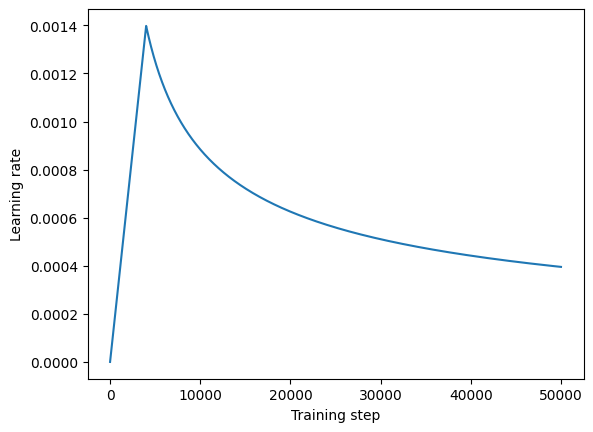

In [43]:
learning_rate = CustomSchedule(model_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

fig, ax = plt.subplots()
ax.plot(learning_rate(tf.range(50_000)))
ax.set_xlabel('Training step')
ax.set_ylabel('Learning rate')

In [44]:
transformer.summary()

Model: "transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │     2,491,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │     4,074,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (64, 77, 4000)         │       516,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,504 (27.01 MB)

 Trainable params: 7,081,504 (27.01 MB)

 Non-trainable params: 0 (0.00 B)

To avoid penalizing masked outputs, we use a custom loss function (see the tutorial):

In [45]:
base_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss(y_true, y_predict):
	loss = base_loss_fn(y_true, y_predict)
	
	unmasked = y_true != 0
	unmasked = tf.cast(unmasked, loss.dtype)
	# Only consider output with a corresponding label.
	loss *= unmasked

	count_unmasked = tf.math.reduce_sum(unmasked)

	# reduce_sum: Adds all entries of a vector.
	return tf.math.reduce_sum(loss)/count_unmasked

In [46]:
def masked_accuracy(y_true, predict_logits):
	predicted_index = tf.math.argmax(predict_logits, axis=-1)
	predicted_index = tf.cast(predicted_index, y_true.dtype)

	match = tf.cast(y_true == predicted_index, tf.float32)
	unmasked = tf.cast(y_true != 0, tf.float32)
	count_unmasked = tf.math.reduce_sum(unmasked)

	return tf.math.reduce_sum(match * unmasked) / count_unmasked


In [47]:
transformer.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

In [27]:
print('From the tutorial:')
vocab_size = float(target_text_processor.vocabulary_size())

print('expected loss', tf.math.log(vocab_size).numpy())
print('expected accuracy', 1/vocab_size)

From the tutorial:
expected loss 8.294049
expected accuracy 0.00025


In [28]:
model.evaluate(dataset_validate, steps=20, return_dict=True)


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8.2964 - masked_accuracy: 5.3719e-04 - masked_loss: 5.8076


/usr/lib64/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 8.296197891235352,
 'masked_accuracy': 0.0005509642069227993,
 'masked_loss': 5.530799388885498}

In [33]:


def test_punctuation(text):
	return '[test]: ' + model.fix_punctuation(text).numpy().decode('utf-8')

class DemoCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch_index: int, logs = None):
		print('\r', test_punctuation([ 'i\'m testing this model\'s performance how well is it working' ]))
		print(test_punctuation([ 'i think it\'s working well, but it\'s really hard to tell why are the question marks missing' ]))
		if epoch_index % 3 == 0:
			# From the test data
			print(test_punctuation([
				'not that alice had any idea of doing that she felt as if she would never be able to talk again, she was getting so much out of breath and still the queen cried faster, faster and dragged her along'
			]))
			print(test_punctuation([ 'tensorflow is a library that is used for machine learning it is available for more languages than just python' ]))
			print(test_punctuation([ 'the joplin note taking app can be used to take multimedia notes' ]))
			print(test_punctuation([ 'here are a few words javascript, typescript, python, joplin, interesting, loud, and sequence these words are all very useful' ]))

test_punctuation(tf.constant([ 'this is an example, they said' ]))

/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information

'[test]: [cap] thi [s] is an example , they said .'

In [34]:
history = model.fit(
	dataset_train,
	epochs = 30,
	steps_per_epoch = 1200,
	validation_data = dataset_validate,
	callbacks=[DemoCallback()]
)

Epoch 1/30


2024-09-10 22:27:35.133542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:63: Filling up shuffle buffer (this may take a while): 48181 of 100000
2024-09-10 22:27:45.854710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.3558 - masked_accuracy: 0.9225 - masked_loss: 0.3558

/usr/lib64/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 [test]: [cap] i ' ll [cap] i test [ing] thi [s] model . [cap] i ' s performance . [cap] how well is it work [ing] .
[test]: [cap] i think it ' s work [ing] well , but it ' s [cap] i ' s real [ly] hard to tell why are the question mark [s] miss [ing] .
[test]: [cap] not that [cap] alice had any idea of doing that she felt as if she would nev [er] be able to talk again , she was gett [ing] so much out of breath and still the [cap] queen - [cap] out [ed] fast [er] , fast [er] and dragg [ed] her along .
[test]: [cap] [UNK] is a library that is used for machine learn [ing] it is available for more language [s] than just [UNK] .
[test]: [cap] the [UNK] note tak [ing] app can be used to take [UNK] note [s] .
[test]: [cap] here are a few word [s] [UNK] , [UNK] , [UNK] , [UNK] , interest [ing] , loud , and sequence these word [s] are all very useful .
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 304s 236ms/step - loss: 0.3558 - masked_accuracy: 0.9225 - masked_loss: 0.3558 - val_loss: 0.3449 - val_masked_ac

2024-09-10 22:52:04.779048: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 [test]: [cap] i ' ll avrigny m test [ing] thi [s] model . [cap] i ' s performance . [cap] how well is it work [ing] .
[test]: [cap] i think it ! [cap] avrigny fath [ing] well , but it ' s real [ly] hard to tell why are the question mark [s] miss [ing] .
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 211s 175ms/step - loss: 0.2532 - masked_accuracy: 0.9448 - masked_loss: 0.2532 - val_loss: 0.2601 - val_masked_accuracy: 0.6295 - val_masked_loss: 0.1734
Epoch 7/30
 [test]: [cap] i don m test [ing] thi [s] model . [cap] i ' s performance . [cap] how well is it work [ing] .cy: 0.9463 - masked_loss: 0.2456
[test]: [cap] i think it ' s work [ing] well , but it . [cap] i couldn ' t real [ly] hard to tell why are the question mark [s] miss [ing] .
[test]: [cap] not that [cap] alice had any idea of doing that she felt as if she would nev [er] be able to talk again , she was gett [ing] so much out of breath and still the queen cri [ed] fast [er] , fast [er] and dragg [ed] her along .
[test]: [cap] [UNK] is a li

KeyboardInterrupt: 

In [46]:

print(test_punctuation([
	'not that alice had any idea of doing that she felt as if she would never be able to talk again she was getting so much out of breath and still the queen cried faster faster and dragged her along'
]))
print(test_punctuation([ 'this is a test of the punctuation system for i am curious how well it works will it work' ]))
print(test_punctuation([ 'this is a test for example, this is a test' ]))

[test]: [cap] not that [cap] alice had any idea of doing that she felt as if she would nev [er] be able to talk again : she was gett [ing] so much out of breath ! [cap] and still the queen cri [ed] fast [er] fast [er] and dragg [ed] her along .
[test]: [cap] thi [s] is a test of the [UNK] system for [cap] i am curiou [s] how well . [cap] it work [s] will it work ?
[test]: [cap] thi [s] is a test for example , thi [s] is a test .


## Exporting

Based on the [Export](https://www.tensorflow.org/text/tutorials/nmt_with_attention#export) section of the tutorial:

In [36]:
class Export(tf.Module):
	def __init__(self, model):
		self.model = model
	
	@tf.function(input_signature=[tf.RaggedTensorSpec(dtype=tf.int64, shape=[None])])
	def fix_punctuation(self, input):
		# Returns encoded tokens
		return model.fix_punctuation_raw(
			tf.reshape(input, [1, -1])
		)

Run `fix_punctuation` once to compile it:

In [37]:
export = Export(model)

In [38]:
sample_inputs = context_text_processor('this sentence shall be punctuated for the following reasons first punctatuion makes things easier to read second um')
model.decoder.tokens_to_text(export.fix_punctuation(sample_inputs))

<tf.Tensor: shape=(), dtype=string, numpy=b'[cap] thi [s] sentence shall be [UNK] [ed] for the follow [ing] reason [s] first [UNK] make [s] thing [s] easi [er] to read second [UNK] .'>

Now we save the model:

In [39]:
tf.saved_model.save(export, 'punctuator-seq2seq', signatures={ 'serving_default': export.fix_punctuation })

/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/self/Documents/punctuation-fixer/env/lib64/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information

INFO:tensorflow:Assets written to: punctuator-seq2seq/assets


INFO:tensorflow:Assets written to: punctuator-seq2seq/assets


See [the documentation](https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export) for information about the `signatures` option.

In [40]:
import json

web_output_dir = Path('web')
vocab_output_file = web_output_dir / 'wordEncodings.ts'

vocab_output_file.write_text('''
// Auto-generated file!
// Created by v2-seq2seq.ipynb
export default {};
'''.format(json.dumps(target_text_processor.get_vocabulary(), indent = '\t')))

43430

### Testing the saved model

In [41]:
reloaded = tf.saved_model.load('punctuator-seq2seq')
# Warmup
reloaded.fix_punctuation(sample_inputs)
print('Imported and warmed up!')

Imported and warmed up!


In [42]:
%%time
model.decoder.tokens_to_text(reloaded.fix_punctuation(sample_inputs))


CPU times: user 175 ms, sys: 78.5 ms, total: 253 ms
Wall time: 97.9 ms


<tf.Tensor: shape=(), dtype=string, numpy=b'[cap] thi [s] sentence shall be [UNK] [ed] for the follow [ing] reason [s] first [UNK] make [s] thing [s] easi [er] to read second [UNK] .'>

In [43]:
context_text_processor('this sentence shall be punctuated for the following reasons first punctatuion makes things easier to read second um')

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([   8,   45,    3, 2553,  193,   40,    1,    7,   28,    5,  139,
         14,  556,    3,   78,    1,  146,    3,  253,    3, 1003,   12,
         13,  385,  214,    1,    9])>